In [1]:
import sys
sys.path.append('../../')

In [2]:
preprocessed_dataset_path = 'preprocessed_dataset/'

In [3]:
from codes.docs.analysis import data_preprocessing, data_exploration, visualisation, data_preprocessing_high_dimension, model_training
from codes.docs.analysis.gene_analysis import genetic_file_preprocess

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict
%matplotlib inline
import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as sfm

from scipy.stats import ttest_ind, pearsonr,zscore
import pandas as pd
import re

Here, the volumetric dataset is preprocessed to group the same brain regions.\
Then mass univariate test is preformed, across multiple regions.

# Main analysis

In [5]:
european_volumetric_dataset_term = pd.read_csv(
    preprocessed_dataset_path +
    'imaging_data/volumetric/term/european_volumetric_df.csv')
mixed_volumetric_dataset_term = pd.read_csv(
    preprocessed_dataset_path +
    'imaging_data/volumetric/term/mixed_volumetric_df.csv')

In [7]:
dependentVar = [
    i for i in european_volumetric_dataset_term.columns
    if bool(re.search('Imperial \d', i)) or bool(re.search('AAL \d',i))
]
# df = european_volumetric_dataset_term.copy()
# df = data_preprocessing.Volumes.Group_Imperial_volumes(df,grouping=None)
# df = data_exploration.MassUnivariate.remove_outliers(df,
#                                                     col=dependentVar,
#                                                      threshold=3,
#                                                     remove_schemes='percentage',
#                                                     percentage_of_outlier=0.1)
for df in [european_volumetric_dataset_term,mixed_volumetric_dataset_term]:
    df = df.rename(columns = {'AAL 93':'AAL 109'})

In [7]:
# imputed_PRS = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/imputed_data/ASD_HPC_merged_0_8_maf_geno_hwe_EUROPEANS.gwas.all.score',column_prefix='PRS_',column_suffix='_ASD_AllLDimputed')

PRS_ASD_EuroLD=genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/ASD_eurold_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',column_prefix = 'PRS_',column_suffix='_ASD_Euro_LD')
# PRS_SCZ_EuroLD = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/scz/SCZ_eur_ld_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',column_prefix = 'PRS_',column_suffix='_SCZ_Euro_LD')
# PRS_ASD_EuroLD_imputed=genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/ASD_eurold_HPC_merged_0_8_maf_geno_hwe_EUROPEANS.gwas.all.score',column_prefix = 'PRS_',column_suffix='_ASD_EuroLDimputed')

df = df.rename(columns={i:i+'_ASD_All_LD' for i in df.columns if 'PRS' in i})

# df = df.merge(imputed_PRS,left_on='ID',right_on=imputed_PRS.index)
df = df.merge(PRS_ASD_EuroLD,left_on='ID',right_on=PRS_ASD_EuroLD.index)
# df = df.merge(PRS_SCZ_EuroLD,left_on='ID',right_on=PRS_SCZ_EuroLD.index)


# df = df.merge(PRS_ASD_EuroLD_imputed,left_on='ID',right_on=PRS_ASD_EuroLD_imputed.index)

In [8]:
df.shape

(205, 4531)

In [9]:
# # plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['patch.edgecolor'] = 'none'
# plt.rcParams["axes.grid.axis"] ="y"
# sns.set_style('whitegrid')
# g = sns.FacetGrid(mixed_volumetric_dataset_term[['GA_vol','PMA_vol','cohort']],col='cohort',height = 4)
# g.map(sns.histplot,'GA_vol',label='GA at birth',color='darkblue',alpha=0.15,shrink=.8)
# g.map(sns.histplot,'PMA_vol',label='PMA at scan',color='darkblue',alpha=0.5,shrink=.8)
# g.set_ylabels('Number of subjects',fontsize=15)
# g.set_xlabels('[weeks]',fontsize=15,fontname='Helvetica')
# g.axes[0][0].set_yticklabels(([int(i) for i in g.axes[0][0].get_yticks()]),size=15)
# g.axes[0][0].set_xticklabels(([int(i) for i in g.axes[0][0].get_xticks()]),size=15)
# g.axes[0][1].set_xticklabels(([int(i) for i in g.axes[0][0].get_xticks()]),size=15)


# g.axes[0][0].set_title('cohort = European',size=15)
# g.axes[0][1].set_title('cohort = Asian',size=15)
# plt.legend(ncol=2,loc='upper center',fontsize=15,frameon=False)
# sns.despine(bottom=True,left=True)
# # g.savefig(f'./{preprocessed_dataset_path}/output_plot/Cohort_age_distribution.pdf',transparent=True)

## AAL atlas

In [10]:
ancestry = ['euro_Anc_PC'+str(i) for i in range(1,4)]
dependentVar = [i for i in df.columns if bool(re.search('AAL \d',i))]
prs = [i for i in df.columns if 'Euro' in i]

In [11]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, LinearSVR
from sklearn.decomposition import PCA

In [12]:
_,independentVar = data_exploration.MassUnivariate.prepare_data(df = df,
                                                                           cat_independentVar_cols=['Gender'],
                                                                          cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry+dependentVar,
                                                                          dependentVar_cols=prs)
independentVar = independentVar.drop(columns='const')

In [14]:
columns_names = [i for i in df.columns if bool(re.search('AAL \d',i))]

In [15]:
pca_scaler = model_training.PCA_adjuster(variables_to_reduce_by_PCA_idx=columns_names,
                           list_of_vars=independentVar.columns.to_list(),n_components=.80)

In [23]:
pipe = Pipeline([('scaler',StandardScaler()),
                ('pca',pca_scaler)])

In [139]:
from sklearn.model_selection import StratifiedKFold

In [122]:
train,test = data_exploration.Stability_tests.train_test_split_modified(df,'GA_vol','PMA_vol',test_size=.1,random_state=1)

In [123]:
dependentVar_train,independentVar_train = data_exploration.MassUnivariate.prepare_data(df = train,
                                                                           cat_independentVar_cols=['Gender'],
                                                                          cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry+columns_names,
                                                                          dependentVar_cols=prs)
independentVar_train = independentVar_train.drop(columns='const')

In [124]:
pipe.fit(independentVar_train.to_numpy())

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 PCA_adjuster(list_of_vars=['GA_vol', 'PMA_vol',
                                            '17 ICV (all except bone)',
                                            'euro_Anc_PC1', 'euro_Anc_PC2',
                                            'euro_Anc_PC3', 'AAL 1', 'AAL 2',
                                            'AAL 3', 'AAL 4', 'AAL 5', 'AAL 6',
                                            'AAL 7', 'AAL 8', 'AAL 9', 'AAL 10',
                                            'AAL 11', 'AAL 12', 'AAL 13',
                                            'AAL 14', 'AAL 15', 'AAL 16',
                                            'AAL 17', 'AAL 18', 'AAL 19',
                                            'AAL 20', 'AAL 21', 'AAL 22',
                                            'AAL 23', 'AAL 24', ...],
                              n_components=0.8,
                              variables_to_reduce_by_PCA_idx=[6,

In [125]:
train_mass_univariates = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df = train,
                                                                                     thresholds = prs,
                                                                                     cont_independentVar_cols=pipe.named_steps['pca'].covariates,
                                                                                     dependentVar_cols=pipe.named_steps['pca'].X_pca
                                                                                    )

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 38.56it/s]


In [136]:
train_mass_univariates.sort_values(by='PRS_pval').head(15)

,Connection,const_coef,const_pval,Cont_0_coef,Cont_0_pval,Cont_1_coef,Cont_1_pval,Cont_2_coef,Cont_2_pval,Cont_3_coef,Cont_3_pval,Cont_4_coef,Cont_4_pval,Cont_5_coef,Cont_5_pval,Cont_6_coef,Cont_6_pval,PRS_coef,PRS_pval,threshold
31,Dependent_Var_3,4.163336e-17,1.0,-0.007071,0.950941,-0.673064,0.000123,0.459295,0.001449,0.050404,0.567462,-0.030248,0.730523,-0.045564,0.600335,-0.053707,0.583459,0.304079,0.000967,PRS_0.0001_ASD_Euro_LD
10,Dependent_Var_3,4.163336e-17,1.0,-0.019495,0.866336,-0.666199,0.000169,0.465640,0.001360,0.060998,0.493531,-0.037367,0.673385,-0.043974,0.616109,-0.108168,0.262332,0.256539,0.004274,PRS_1e-07_ASD_Euro_LD
45,Dependent_Var_3,4.163336e-17,1.0,0.016351,0.888600,-0.750845,0.000023,0.505542,0.000511,0.069672,0.437615,-0.055434,0.536561,-0.037905,0.666060,-0.095832,0.324548,0.240697,0.007867,PRS_0.01_ASD_Euro_LD
38,Dependent_Var_3,4.163336e-17,1.0,-0.001030,0.992967,-0.701960,0.000078,0.501037,0.000603,0.059882,0.505027,-0.044720,0.618079,-0.031998,0.716418,-0.107215,0.270853,0.213316,0.018306,PRS_0.001_ASD_Euro_LD
3,Dependent_Var_3,4.163336e-17,1.0,-0.037242,0.750468,-0.686086,0.000118,0.481925,0.000984,0.051910,0.562290,-0.031316,0.725638,-0.035335,0.688680,-0.114128,0.240209,0.208930,0.018497,PRS_1e-08_ASD_Euro_LD
52,Dependent_Var_3,4.163336e-17,1.0,0.002329,0.984112,-0.735570,0.000035,0.495586,0.000697,0.064580,0.473631,-0.042035,0.639160,-0.024548,0.780295,-0.103130,0.290769,0.206765,0.020884,PRS_0.05_ASD_Euro_LD
59,Dependent_Var_3,4.163336e-17,1.0,-0.009149,0.937749,-0.729731,0.000043,0.499550,0.000656,0.062302,0.490822,-0.045897,0.611225,-0.024209,0.783933,-0.113737,0.243954,0.183740,0.039918,PRS_0.1_ASD_Euro_LD
43,Dependent_Var_1,-4.163336e-17,1.0,-0.052444,0.731072,-0.120534,0.593733,-0.029258,0.875581,-0.013044,0.911390,0.058819,0.615796,-0.296358,0.010524,-0.241742,0.058193,0.207980,0.077224,PRS_0.01_ASD_Euro_LD
66,Dependent_Var_3,4.163336e-17,1.0,-0.022424,0.848815,-0.728276,0.000047,0.493401,0.000803,0.065268,0.474296,-0.034171,0.704472,-0.020422,0.817622,-0.113534,0.246949,0.156550,0.081996,PRS_0.5_ASD_Euro_LD
61,Dependent_Var_5,2.602085e-17,1.0,0.275211,0.008642,-0.572486,0.000270,0.284930,0.026745,0.021991,0.783550,-0.081214,0.310451,0.214113,0.006744,-0.174052,0.044946,-0.133502,0.091308,PRS_0.1_ASD_Euro_LD


In [127]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz')

<AxesSubplot:>

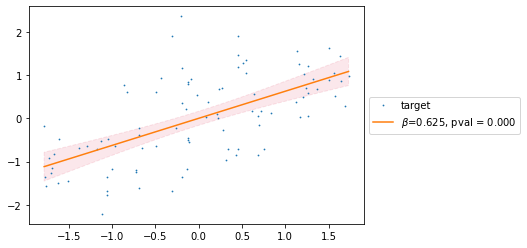

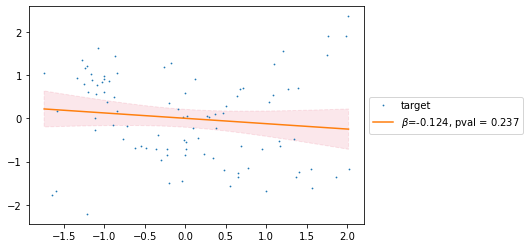

In [138]:
visualisation.plot_Linear_Reg(ROIs_coord.loc[0:92,'Y'],pipe.named_steps['pca'].pca.components_[3])
visualisation.plot_Linear_Reg(ROIs_coord.loc[0:92,'Z'],pipe.named_steps['pca'].pca.components_[3])

In [129]:
dependentVar_test,independentVar_test = data_exploration.MassUnivariate.prepare_data(df = test,
                                                                           cat_independentVar_cols=['Gender'],
                                                                          cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry+columns_names,
                                                                          dependentVar_cols=prs)
independentVar_test = independentVar_test.drop(columns='const')

In [130]:
new_X_pca = pipe.transform(independentVar_test.to_numpy())

In [131]:
new_X_pca.shape

(21, 14)

In [132]:
test_mass_univariates = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df = test,
                                                                                     thresholds = prs,
                                                                                     cont_independentVar_cols=new_X_pca[:,7:],
                                                                                     dependentVar_cols=new_X_pca[:,3]
                                                                                    )

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 82.56it/s]


In [133]:
test_mass_univariates.sort_values(by='PRS_pval').head(10)

,Connection,const_coef,const_pval,Cont_0_coef,Cont_0_pval,Cont_1_coef,Cont_1_pval,Cont_2_coef,Cont_2_pval,Cont_3_coef,Cont_3_pval,Cont_4_coef,Cont_4_pval,Cont_5_coef,Cont_5_pval,Cont_6_coef,Cont_6_pval,PRS_coef,PRS_pval,threshold
6,Dependent_Var_0,6.938894e-17,1.0,0.207373,0.392733,-1.263748,0.000472,0.849706,0.002301,-0.261191,0.163556,-0.076459,0.720536,0.063061,0.775338,0.196918,0.363149,0.544377,0.004153,PRS_0.01_ASD_Euro_LD
10,Dependent_Var_0,6.938894e-17,1.0,0.407020,0.171448,-1.418432,0.000859,0.852866,0.006216,-0.024144,0.903957,-0.296093,0.244549,-0.048681,0.847912,0.061373,0.802934,0.443688,0.031426,PRS_1_ASD_Euro_LD
7,Dependent_Var_0,6.938894e-17,1.0,0.367889,0.218480,-1.220289,0.002321,0.804518,0.010309,-0.098064,0.632784,-0.165300,0.514075,-0.011790,0.963917,0.103354,0.681719,0.401646,0.042467,PRS_0.05_ASD_Euro_LD
9,Dependent_Var_0,6.938894e-17,1.0,0.395233,0.195790,-1.394667,0.001204,0.855472,0.007362,-0.002225,0.991453,-0.264140,0.308171,-0.059872,0.819100,0.087220,0.731126,0.412357,0.047934,PRS_0.5_ASD_Euro_LD
2,Dependent_Var_0,6.938894e-17,1.0,0.238514,0.430819,-1.124591,0.005753,0.700398,0.032592,-0.051550,0.809707,-0.127382,0.634090,-0.044562,0.870033,0.053234,0.840146,0.351883,0.082351,PRS_1e-06_ASD_Euro_LD
8,Dependent_Var_0,6.938894e-17,1.0,0.339617,0.274799,-1.185744,0.003975,0.732134,0.025127,-0.093956,0.663101,-0.221971,0.405837,0.061418,0.827934,0.110873,0.676050,0.383952,0.085721,PRS_0.1_ASD_Euro_LD
3,Dependent_Var_0,6.938894e-17,1.0,0.180892,0.560221,-1.512914,0.001959,0.921208,0.007025,-0.175521,0.446799,-0.086878,0.755481,0.126743,0.676174,0.178732,0.519268,0.443061,0.112513,PRS_1e-05_ASD_Euro_LD
0,Dependent_Var_0,6.938894e-17,1.0,0.143920,0.654729,-1.031205,0.015540,0.680276,0.050900,0.003135,0.989024,-0.068164,0.814770,-0.050757,0.858303,0.075835,0.782912,0.320943,0.154550,PRS_1e-08_ASD_Euro_LD
4,Dependent_Var_0,6.938894e-17,1.0,0.267815,0.409061,-1.561028,0.004733,1.056085,0.007671,-0.163544,0.502500,-0.235461,0.409311,-0.093117,0.749649,0.092163,0.744075,0.359970,0.226935,PRS_0.0001_ASD_Euro_LD
5,Dependent_Var_0,6.938894e-17,1.0,0.320813,0.334084,-1.381903,0.003684,0.969776,0.008395,-0.163878,0.504895,-0.294897,0.319344,-0.119566,0.685713,0.002606,0.992845,0.259370,0.242410,PRS_0.001_ASD_Euro_LD


In [61]:
pipe.named_steps['pca'].X_pca.shape

(102, 5)

In [34]:
pca_scaler.covariates.shape[1]

7

In [25]:
data_exploration.MassUnivariate.mass_univariate(cont_independentVar_cols=pca_scaler.covariates,
                                               dependentVar_cols=pca_scaler.X_pca)

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7faefdb45550>,
                    const_coef  const_pval  Cont_0_coef  Cont_0_pval  \
 Dependent_Var_0  2.220446e-16         1.0    -0.233361     0.099901   
 Dependent_Var_1  1.040834e-16         1.0     0.290522     0.220988   
 Dependent_Var_2  6.938894e-17         1.0    -0.341171     0.091035   
 Dependent_Var_3 -1.387779e-17         1.0     0.020836     0.912247   
 Dependent_Var_4 -1.249001e-16         1.0    -0.159459     0.320879   
 
                  Cont_1_coef  Cont_1_pval  Cont_2_coef   Cont_2_pval  \
 Dependent_Var_0     0.399012     0.062150     7.928177  1.491566e-66   
 Dependent_Var_1    -0.254000     0.475966     0.206976  4.728614e-01   
 Dependent_Var_2     1.039196     0.000826    -0.687578  5.765722e-03   
 Dependent_Var_3     0.431477     0.131788    -0.359228  1.211080e-01   
 Dependent_Var_4     0.875618     0.000445    -0.500562  1.167368e-02   
 
                  Cont_3_coef  Cont_3_pval 

In [23]:
set1_mass_univariates

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
0,Dependent_Var_0,0.152570,0.288985,-0.216932,0.131803,0.377604,0.081003,7.943010,9.347067e-66,-0.007850,0.935334,-0.137436,0.171437,-0.014972,0.878718,-0.070035,0.478189,-0.317594,0.157282,PRS_1e-08_ASD_Euro_LD
1,Dependent_Var_1,-0.278160,0.248116,0.248323,0.300874,-0.199012,0.579709,0.168877,5.603793e-01,0.026084,0.871979,-0.004682,0.977671,0.215181,0.191896,0.179887,0.277075,0.579028,0.123620,PRS_1e-08_ASD_Euro_LD
2,Dependent_Var_2,0.105864,0.600372,-0.289549,0.152769,0.971929,0.001736,-0.640971,9.832760e-03,0.034120,0.802218,-0.007666,0.956567,0.284371,0.041751,-0.220059,0.115347,-0.220369,0.483945,PRS_1e-08_ASD_Euro_LD
3,Dependent_Var_3,0.033484,0.861885,0.045928,0.810911,0.398780,0.168258,-0.336574,1.497850e-01,0.004802,0.970490,-0.064912,0.628671,0.360057,0.007308,-0.106965,0.419628,-0.069702,0.816088,PRS_1e-08_ASD_Euro_LD
4,Dependent_Var_4,-0.188967,0.245901,-0.126242,0.436076,0.832334,0.000879,-0.470571,1.799924e-02,0.101113,0.356630,0.133014,0.241301,-0.218337,0.051501,-0.141602,0.206242,0.393360,0.121875,PRS_1e-08_ASD_Euro_LD
5,Dependent_Var_0,0.161961,0.261886,-0.209781,0.144980,0.353572,0.106489,7.955466,1.239201e-65,-0.010254,0.915376,-0.125937,0.212454,-0.006227,0.949782,-0.096970,0.348102,-0.337143,0.136143,PRS_1e-07_ASD_Euro_LD
6,Dependent_Var_1,-0.274804,0.258597,0.270301,0.263916,-0.215033,0.557744,0.183575,5.317293e-01,0.032242,0.842827,-0.013852,0.934858,0.220705,0.187297,0.083156,0.632392,0.572040,0.133465,PRS_1e-07_ASD_Euro_LD
7,Dependent_Var_2,0.124489,0.539581,-0.283058,0.162634,0.927209,0.003134,-0.620325,1.286796e-02,0.026573,0.845074,0.020400,0.885561,0.300766,0.032975,-0.238983,0.102455,-0.259141,0.414303,PRS_1e-07_ASD_Euro_LD
8,Dependent_Var_3,0.037460,0.846660,0.041628,0.828964,0.391409,0.183429,-0.335167,1.548270e-01,0.001137,0.993019,-0.055033,0.684577,0.362854,0.007505,-0.085504,0.538325,-0.077978,0.796773,PRS_1e-07_ASD_Euro_LD
9,Dependent_Var_4,-0.166501,0.303747,-0.106676,0.507002,0.773902,0.002005,-0.439478,2.637980e-02,0.096251,0.375068,0.158841,0.161533,-0.197112,0.078095,-0.217064,0.063069,0.346593,0.171733,PRS_1e-07_ASD_Euro_LD


In [55]:
model_summary = model_training.NestedCV.perform_nestedcv(
    pipe,df = df,bins=2,
                                          cat_independentVar_cols=['Gender'],
                                          cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry+columns_names,
                                          dependentVar_cols=prs,n_splits=3,scoring='r2')

In [56]:
pd.DataFrame({i:[model_summary[i][split]['test_r2_score'] for split in model_summary[i].keys()] for i in prs}).T

,0,1,2
PRS_1e-08_ASD_Euro_LD,-0.203171,-0.005448,-0.052502
PRS_1e-07_ASD_Euro_LD,-0.068232,0.057059,-0.049456
PRS_1e-06_ASD_Euro_LD,-0.287125,0.070573,-0.024034
PRS_1e-05_ASD_Euro_LD,-0.005510,-0.003562,-0.164821
PRS_0.0001_ASD_Euro_LD,0.026407,0.045557,-0.108104
PRS_0.001_ASD_Euro_LD,0.030127,0.053427,-0.042215
PRS_0.01_ASD_Euro_LD,0.042415,-0.120966,0.114993
PRS_0.05_ASD_Euro_LD,0.045222,-0.104087,-0.084327
PRS_0.1_ASD_Euro_LD,0.049147,-0.120371,-0.192523
PRS_0.5_ASD_Euro_LD,0.026935,-0.175751,-0.280489


In [ ]:
lin_reg

In [101]:
pd.DataFrame({i:[model_summary[i][split]['cv_r2_score'] for split in model_summary[i].keys()] for i in prs}).T

,0,1,2
PRS_1e-08_ASD_Euro_LD,"[0.020470588159416603, -0.030608108131903622, ...","[0.0035446024944549848, -0.03205312493637047, ...","[-0.0933690340822182, 0.021245454512250905, -0..."
PRS_1e-07_ASD_Euro_LD,"[0.028622948109082613, -0.11943668589158052, -...","[0.08869516524974885, 0.033538265270392054, -0...","[-0.1969097433667275, 0.12649983344128812, 0.0..."
PRS_1e-06_ASD_Euro_LD,"[-0.021763730344513066, -0.17889472312135668, ...","[-0.03485112592143613, 0.017695333549868297, -...","[-0.14582677552988166, 0.015913836765960254, -..."
PRS_1e-05_ASD_Euro_LD,"[-0.009747745672150199, -0.04758339578897641, ...","[0.06831726508310632, -0.015003485302910402, -...","[0.0646333089211042, 0.1115732199981182, -0.04..."
PRS_0.0001_ASD_Euro_LD,"[0.09368072487900514, 0.002127412801282369, -0...","[0.1684213043381918, -0.002749219741268183, -0...","[-0.2031405275681526, -0.04403843196028623, 0...."
PRS_0.001_ASD_Euro_LD,"[-0.09429761555810168, 0.07971829508553163, -0...","[-0.13350516026505566, -0.05526365805027744, -...","[-0.005012461888782349, 0.01791844643788132, -..."
PRS_0.01_ASD_Euro_LD,"[-0.06081412484963322, 0.017845013759780537, 0...","[0.020432791360621705, 0.0757909214228285, 0.0...","[-0.021906400602517584, -0.038764601825013845,..."
PRS_0.05_ASD_Euro_LD,"[0.03310251333810721, -0.004245412567063456, -...","[0.03748706675055047, 0.03864127283238905, 0.0...","[-0.17642315882763682, -0.1361204049885092, 0...."
PRS_0.1_ASD_Euro_LD,"[-0.061234689842185164, -0.17364594983998272, ...","[0.05087274736022296, 0.022822956908664427, -0...","[-0.09858408655429107, 0.05522984993080826, 0...."
PRS_0.5_ASD_Euro_LD,"[-0.15386737625798852, -0.1626773873861802, 0....","[-0.022357712837534294, 0.02508059562831022, -...","[0.0444335624837503, -0.12138032232283424, -0...."


In [110]:
prs_ = 'PRS_0.01_ASD_Euro_LD'
y_test_pred_dict = {i:{'y_pred':model_summary[prs_][i]['y_pred'],
   'y_test':model_summary[prs_][i]['y_test'],'split':[i for n in range(len(model_summary[prs_][i]['y_test']))]} for i in model_summary[prs_].keys()}

In [111]:
y_test_pred_dict = pd.concat([pd.DataFrame(y_test_pred_dict[i]) for i in y_test_pred_dict.keys()])

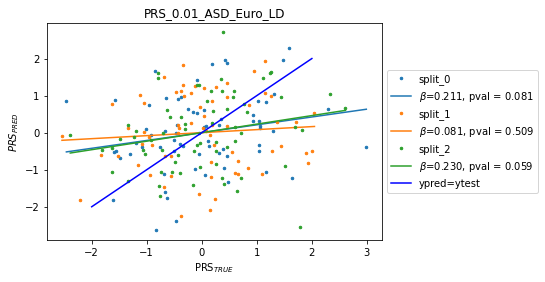

In [112]:
ax = visualisation.plot_Linear_Reg(data = y_test_pred_dict, x = 'y_test', y = 'y_pred',markersize=5,scaling='both',hue='split',hide_CI=True,xlabel=r'PRS$_{TRUE}$',ylabel=r'$PRS_{PRED}$',title=f'{prs_}')
ax.plot([-2,2],[-2,2],'b-',label='ypred=ytest')
ax.legend(loc='center left',bbox_to_anchor=(1,0.5))

In [104]:
lin_reg = LinearRegression()

In [72]:
y,X = data_exploration.MassUnivariate.prepare_data(df = df,
                                          cat_independentVar_cols=['Gender'],
                                          cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry+dependentVar,
                                                  dependentVar_cols=prs)

,const,GA_vol,PMA_vol,17 ICV (all except bone),euro_Anc_PC1,euro_Anc_PC2,euro_Anc_PC3,AAL 1,AAL 2,AAL 3,...,AAL 85,AAL 86,AAL 87,AAL 88,AAL 89,AAL 90,AAL 91,AAL 92,AAL 109,Gender_2.0
0,1.0,-0.867947,0.308270,1.838078,0.707933,0.072990,0.254428,1.037355,0.720263,1.954052,...,1.494046,2.006972,1.142841,1.242644,1.554399,1.874374,1.161712,1.020085,0.765372,0
1,1.0,-0.296195,0.308270,0.785095,-1.895899,0.408387,-2.257130,1.201847,0.931634,1.279001,...,0.124951,0.326012,0.776416,-0.109148,0.737017,0.062129,0.499356,0.639860,0.064510,0
2,1.0,-0.867947,0.811151,0.894440,-2.378463,-2.017302,-0.191470,1.129626,1.306049,0.556969,...,0.305463,1.077255,2.002414,1.625938,0.837295,0.612762,1.318961,0.958324,2.131004,0
3,1.0,1.190359,0.811151,1.607367,0.696581,0.640625,-1.137209,1.746550,1.301531,1.158332,...,1.690517,1.031688,0.422968,0.433344,1.595844,1.629106,1.593206,1.246643,1.860469,0
4,1.0,1.533410,1.062591,1.384905,1.023702,-0.120918,-0.394134,1.703406,0.999604,1.326147,...,1.333297,0.827409,-0.571724,-0.073647,0.949096,0.924231,0.928284,0.800947,1.262021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,1.0,0.504257,-0.278424,-0.785043,0.314708,0.218152,1.565692,-0.812053,-0.615507,-0.895339,...,-0.565591,-0.778999,-0.858757,0.011776,-0.364415,-0.862511,-0.765616,-0.708282,-0.418876,0
201,1.0,1.419060,0.308270,-0.177393,0.893955,-0.578483,0.056851,-0.556549,-0.386908,-0.229354,...,0.386582,0.208916,-0.449582,-0.822486,-0.300125,-0.314727,0.269697,0.363599,0.225227,1
202,1.0,-1.897100,0.643524,0.018181,0.711032,-0.018205,0.894654,0.160938,0.394489,-0.327604,...,-0.548970,0.320820,-0.406069,0.001237,0.430929,-0.194806,-0.148887,0.172752,-0.037288,1
203,1.0,0.847308,0.643524,0.690544,0.130952,-1.068898,0.989428,0.633420,1.031961,0.811328,...,0.791183,0.764715,0.519155,0.432789,0.680005,0.534352,0.864534,1.091121,0.679923,1
